# EECS 545 (WN 2024) Homework 4: Transformers

<span class="instruction">Before starting the assignment, please fill in the following cell.</span>

In [14]:
###################################################################
# Enter your first and last name, e.g. "John Doe"                 #
# for example                                                     #
# __NAME__ = "Violet Fu"                                          #
# __UNIQID__ = "violetfy"                                         #
###################################################################
# raise NotImplementedError("TODO: Add your implementation here.")
__NAME__ = "Wensong Hu"
__UNIQID__ = "umhws" 
###################################################################
#                        END OF YOUR CODE                         #
###################################################################

print(f"Your name and email: {__NAME__} <{__UNIQID__}@umich.edu>")
assert __NAME__ and __UNIQID__

Your name and email: Wensong Hu <umhws@umich.edu>


# Transformer on text generation 
In this notebook, you will test the Attention Module and the PyTorch training code you implemented in **transformer.py** and **transformer_trainer.py**. This requires running code in PyTorch. Ideally, you should run this file on <span style="color: violet;">**GPU**</span>. If it is not available on your own machine, we recommand running on <span style="color: violet;">**Colab**</span>. Please refer to this [instruction](https://docs.google.com/document/d/e/2PACX-1vSgRhviaU_N_ErIwytT6vJ52gxmjiBcRGDs7q80qeifOVyuRkwZYchXMFn-HU0UjXrvmGzR2fB9QsOz/pub) about how to use Colab. If you evenatually decide to run everything with **CPU**, please start early and allocate at least a few hours for section(C) as it is going to take long. 

## Setup code
Before getting started, we need to run some boilerplate code to set up our environment. You'll need to rerun this setup code each time you start the notebook. Let's start by checking whether we are using Python 3.11 or higher.

In [3]:
import sys
if sys.version_info[0] < 3:
    raise Exception("You must use Python 3")

if sys.version_info[1] < 11:
    print("Autograder will execute your code based on Python 3.11 environment. Please use Python 3.11 or higher to prevent any issues")
    print("You can create a conda environment with Python 3.11 like 'conda create --name eecs545 python=3.11'")
    raise Exception("Python 3 version is too low: {}".format(sys.version))
else:
    print("You are good to go")

You are good to go


First, run this cell load the [autoreload](https://ipython.readthedocs.io/en/stable/config/extensions/autoreload.html) extension. This allows us to edit `.py` source files, and re-import them into the notebook for a seamless editing and debugging experience.

In [4]:
%load_ext autoreload
%autoreload 2

Then, we run some setup code for this notebook: Import some useful packages and increase the default figure size.

In [5]:
# Uncomment the lines below to install packages if they are not installed yet. 
# !pip install numpy==1.24.1 matplotlib==3.6.2 scikit-learn==1.2.0 imageio==2.25.1
import os
import sys
import json
import random

import numpy as np
import matplotlib.pyplot as plt

Next, we need to make sure pytorch is installed. The following command will install pytorch if you haven't installed it before. Depending on your OS and GPU hardware, this may install a CPU or GPU version. If you want to use a GPU with PyTorch (which will exponentially speed up your computation time) you can follow the instructions on the pytorch [official website](https://pytorch.org/get-started/locally/). In this problem set a CPU-only pytorch is sufficient.

In [6]:
# uncomment and run the line below to install pytorch is you haven't done so
# !pip install torch==2.2.1 torchvision==0.17.1
import torch
from torch.utils.data import Dataset
from torch.utils.data.dataloader import DataLoader

In [7]:
# check if CUDA is available on torch
print('PyTorch CUDA is available?', torch.cuda.is_available())

PyTorch CUDA is available? True


To reproduce results, it is important to set seed. The function below helps to do so.

In [8]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    
set_seed(12345) #set a fixed random seed

### Section(A) Check your attention implementation
Now, let's check your transformer implementation. A correct implementation should pass the assert_allclose line and does not trigger any error. 

In [9]:
from transformer import MaskedAttention
set_seed(12345)
attention = MaskedAttention(48, 3, 3)
inputs = [[[ 0.8852, -1.1841,  0.4406,  0.6939, -0.8548, -0.7011,  0.2941,
           0.6334,  1.6439,  0.2185, -1.8231,  0.3305, -3.6633, -0.5477,
          -1.5629,  1.3776, -2.3223,  1.1882, -1.0146,  0.4610, -0.6772,
           1.0473,  0.6797, -1.3599,  0.5765,  1.3818,  1.9596,  0.2333,
           0.4236,  1.5104,  0.5365, -1.2894,  1.0061,  0.0317,  0.9216,
           0.8358, -0.0778,  0.2040,  0.5083, -1.4204, -0.5308,  0.5121,
           1.4943,  1.3703,  0.4305,  1.2011, -1.8800, -0.1506],
         [-0.1161,  1.0082,  1.1272,  1.0432, -0.5849, -1.9456, -0.5046,
          -0.0495, -0.1723, -0.7835,  0.0706, -1.1203, -0.5606,  0.6311,
          -0.4215, -1.4242,  0.5186,  1.2899, -1.6057, -0.7066,  0.0234,
           0.0535, -0.1760,  2.7153, -0.3977,  0.4018,  1.7233, -0.4099,
           0.8925, -1.6363,  0.5603,  0.8228, -0.6935,  0.5939,  0.0261,
          -0.8228,  1.0020,  0.8776,  0.2597,  0.5770, -0.7814,  0.4137,
          -3.1109,  1.5095, -1.3054, -0.2762, -0.2339, -0.0605],
         [-0.9684,  0.8253,  1.1051, -0.7230,  0.3950, -0.3346, -0.0271,
          -1.6035, -0.3299,  0.6642, -0.4004, -0.6389, -0.2243,  0.8469,
          -1.0028, -0.2318,  1.4500,  0.1103,  1.2395,  0.2621,  1.8836,
          -0.6182,  2.1644,  1.5504,  3.0542,  0.9740, -2.8405,  0.8848,
           0.2762, -0.7397,  1.5389, -0.6161, -0.3589, -0.0085,  0.1275,
          -0.2849, -0.6918, -1.7355, -1.0572, -0.4486, -0.5446,  0.8705,
           0.8601, -0.1449,  1.4177, -0.2919,  0.7602,  0.4350]]]
inputs = torch.tensor(inputs).float()
attention.eval()
with torch.no_grad():
    outputs = attention(inputs)
expected_outputs = np.array([[[-0.1486,  0.1777, -0.3494, -0.2162, -0.1077,  0.0685, -1.0346,
                              -0.6672, -0.8616, -0.3380,  0.2046, -0.0050, -0.0738,  0.1913,
                               0.1332, -0.3641, -0.4243,  0.1188,  0.0215,  0.2370,  0.6812,
                              -0.1018,  0.0788, -0.6371, -0.4669,  0.6068,  0.1693,  0.1214,
                              -0.8412, -0.1185, -0.2494,  0.4053,  0.3242, -0.0280,  0.3158,
                              -0.2219,  0.1630, -0.0745, -0.1231, -0.6197,  0.5833, -0.3247,
                               0.3002, -0.1323, -0.4823, -0.5536, -0.1559,  0.5801],
                             [ 0.0702,  0.1089, -0.4341, -0.0671, -0.2151, -0.0183, -0.5890,
                              -0.6078, -0.8475, -0.4055, -0.1759, -0.0395, -0.0636,  0.2831,
                               0.0722, -0.1965, -0.2158,  0.1390, -0.2303,  0.2821,  0.5404,
                               0.0640,  0.1459, -0.4615, -0.3691,  0.2262,  0.1783, -0.0748,
                              -0.6773, -0.1486, -0.0890,  0.5385,  0.0556,  0.0576,  0.1533,
                              -0.0288,  0.0889, -0.0435, -0.1417, -0.2416,  0.4084, -0.2700,
                               0.0975, -0.1606, -0.4313, -0.4773, -0.0866,  0.2469],
                             [-0.1378, -0.1708, -0.2168, -0.0777, -0.0604,  0.0068, -0.6403,
                              -0.3968, -0.3044, -0.1192, -0.4150,  0.2027,  0.0118,  0.1063,
                              -0.1213,  0.2542,  0.0388, -0.0865, -0.2399, -0.0096,  0.3200,
                               0.0793,  0.0022, -0.1296, -0.0470,  0.1209,  0.0395,  0.3965,
                              -0.2515, -0.3861, -0.3169,  0.0824,  0.2049,  0.1243, -0.1657,
                               0.0492, -0.1103,  0.1369,  0.1256, -0.4973,  0.1020, -0.1457,
                               0.1124, -0.2355, -0.4387, -0.4518, -0.0035,  0.0864]]])

np.testing.assert_allclose(outputs.cpu().numpy(), expected_outputs, atol=1e-3)
print("Passed!")

Passed!


### Section(B) Train your model to learn multiplication. 
The code base below is a math multiplication dataset for n-digit multiplication. Specifically, we are focusing on 2-digit multiplication problem in this homework, for example, for input 54x45, the expected output is 2430.

In [10]:
class DigitMultiplicationDataset(Dataset):
    def __init__(self, n, data_comb, split):
        self.n = n # max number of digit
        n_train = int(0.8*data_num)
        self.data = data_comb[:n_train] if split == 'train' else data_comb[n_train:]

    def get_block_size(self):
        return 4*self.n - 1

    def __len__(self):
        return self.data.nelement()

    def digit_to_str(self, x, ndigit):
        return f'%0{ndigit}d' % x

    def str_to_digit(self, x, device):
        factors = torch.tensor([[10**i for i in range(x.shape[-1])][::-1]]).to(device)
        return (x * factors).sum(dim=1)

    def __getitem__(self, idx):
        inputs = self.data[idx].item()
        a, b = inputs // (10**self.n), inputs % (10**self.n)
        c = a * b # target
        # encode digits
        astr = self.digit_to_str(a, self.n)
        bstr = self.digit_to_str(b, self.n)
        cstr = self.digit_to_str(c, 2*self.n) #2-digit numbers multiply to up to 4 digits.
        # we ignore * symbol because we only finetune on multiplication. 
        concat_str = f'{astr}{bstr}{cstr[::-1]}'
        concat = [int(s) for s in concat_str]
        x = torch.tensor(concat[:-1]).long() #given the sequence 01020
        y = torch.tensor(concat[1:]).long() #predict the next digit 10203
        y[:self.n*2-1] = -100 #masked out input
        return x, y

# generate data
ndigit=2
rng = torch.Generator()
rng.manual_seed(1337)
data_num = (10**ndigit)**2
data_comb = torch.randperm(data_num, generator=rng)

Run the code below to train a model that learns 2-digit number multiplication!

If you are worried that the training break and you lose the training progress, you can refer to [PyTorch checkpoint](https://pytorch.org/tutorials/recipes/recipes/saving_and_loading_a_general_checkpoint.html) to save and load checkpoints while you train. Generally this will not happen for small models with short training time if you run on GPU. 

In [11]:
from transformer import GPT
from transformer_trainer import Trainer, Evaluator

set_seed(12345)
train_dataset = DigitMultiplicationDataset(ndigit, data_comb, split='train')
test_dataset = DigitMultiplicationDataset(ndigit, data_comb, split='test')
n_layer, n_head, embedding_dim = 4, 4, 128
multip_model = GPT(n_layer, 
                   n_head,
                   embedding_dim, 
                   10, # 10 possible digits
                   train_dataset.get_block_size())

learning_rate = 1e-3
max_iters=20000 
multip_trainer = Trainer(multip_model, train_dataset, learning_rate, max_iters=max_iters)
multip_trainer.test_dataset = test_dataset
multip_trainer.run('multiplication')

running on cuda
Iteration 1/20000: training loss 2.3560
train accuracy: 1.93%
Iteration 501/20000: training loss 1.2098
train accuracy: 4.04%
Iteration 1001/20000: training loss 0.9928
train accuracy: 7.00%
Iteration 1501/20000: training loss 1.0348
train accuracy: 10.20%
Iteration 2001/20000: training loss 0.8772
train accuracy: 12.96%
Iteration 2501/20000: training loss 0.8415
train accuracy: 18.11%
Iteration 3001/20000: training loss 0.7016
train accuracy: 22.52%
Iteration 3501/20000: training loss 0.6001
train accuracy: 28.27%
Iteration 4001/20000: training loss 0.6548
train accuracy: 33.74%
Iteration 4501/20000: training loss 0.5510
train accuracy: 38.96%
Iteration 5001/20000: training loss 0.5786
train accuracy: 41.65%
Iteration 5501/20000: training loss 0.4455
train accuracy: 51.94%
Iteration 6001/20000: training loss 0.4365
train accuracy: 56.51%
Iteration 6501/20000: training loss 0.3945
train accuracy: 66.15%
Iteration 7001/20000: training loss 0.2833
train accuracy: 79.17%
I

Now let's evaluate the trained model on the held-out test dataset to see if it overfits. How does it perform? Please report the final training/testing accuracy.

In [12]:
set_seed(12345)
Evaluator(test_dataset, multip_model, 'test').eval_split(multip_trainer.device, print_example=20)

test accuracy: 95.95%
Prediction: 26 x 61 = 1586, correct answer: 1586
Prediction: 19 x 12 = 228, correct answer: 228
Prediction: 31 x 92 = 2852, correct answer: 2852
Prediction: 44 x 53 = 2332, correct answer: 2332
Prediction: 89 x 8 = 712, correct answer: 712
Prediction: 91 x 88 = 8008, correct answer: 8008
Prediction: 6 x 59 = 354, correct answer: 354
Prediction: 39 x 34 = 1326, correct answer: 1326
Prediction: 94 x 35 = 3290, correct answer: 3290
Prediction: 28 x 20 = 560, correct answer: 560
Prediction: 54 x 98 = 5292, correct answer: 5292
Prediction: 91 x 79 = 7189, correct answer: 7189
Prediction: 79 x 52 = 4108, correct answer: 4108
Prediction: 78 x 59 = 4602, correct answer: 4602
Prediction: 35 x 8 = 280, correct answer: 280
Prediction: 71 x 33 = 2343, correct answer: 2343
Prediction: 1 x 10 = 10, correct answer: 10
Prediction: 64 x 79 = 5056, correct answer: 5056
Prediction: 5 x 8 = 40, correct answer: 40
Prediction: 69 x 20 = 1380, correct answer: 1380


Now, let's plot the training loss. 

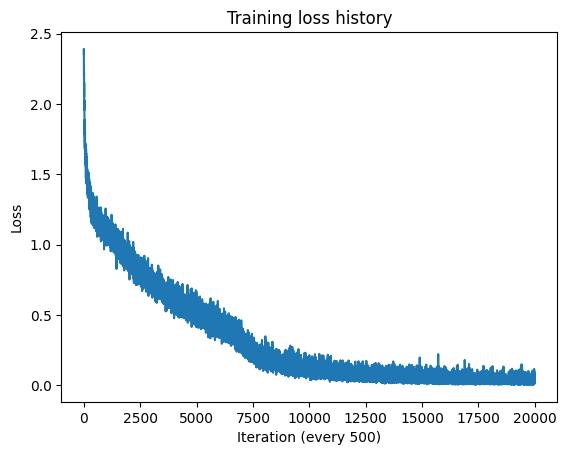

In [13]:
plt.plot(multip_trainer.train_losses)
plt.xlabel(f'Iteration (every {multip_trainer.log_interval})')
plt.ylabel('Loss')
plt.title('Training loss history')
plt.savefig('multiplication_loss.png', dpi=256)
plt.show()
plt.close()

# Section(C) Train a model to tell stories!
Now, let's train a model to tell short stories! 
We are going to train the model on the [tiny stories](https://huggingface.co/datasets/roneneldan/TinyStories/tree/main). Please open the link, 
download the **TinyStories-train.txt** file, and put it in your **data** folder like below. 
```
HW4 /
--| transformer.ipynb
--| data /
----| TinyStories-train.txt
----| ...
```
Here is one example: 
*One day, a little girl wanted to paint. She went outside, and looked around. The grass was green, and the sky was blue. It was a mild day, so it was perfect for painting.
The little girl began to paint, and she used all the colors from her box of paints. Red, yellow, and blue. She painted on the grass, and she made a beautiful picture.
She painted flowers and birds, and she was very proud of her work. The sun was shining, so everything looked very bright.
When she was finished, she stood up and looked at her painting. She felt very happy, because she had made something beautiful. She knew she would always remember this mild day and the painting she made on the grass.
After this, run the code in the cell below to load the stories.*

Now let's load the dataset you download and run the cell below to convert the loaded stories to a dataset class to use.

In [16]:
file_path = './data/TinyStories-train.txt'
unique_chars = set()
data_len = 0
with open(file_path, 'rb') as file:
    while True:
        chunk = file.read(int(1e7)) #we do this in chunk to make it compatible with limited memory
        chunk = chunk.decode('utf-8')
        data_len += len(chunk)
        print(data_len)
        if not chunk:
            break 
        for char in chunk:
            unique_chars.add(char)
sorted_unique_chars = sorted(unique_chars)
assert data_len == 1922767089

9990541
19986053
29979590
39972496
49964221
59954744
69947926
79940655
89933160
99928581
109919710
119910748
129902928
139896391
149888178
159881199
169873894
179869931
189863959
199856631
209848705
219841890
229833658
239825767
249818837
259807060
269801357
279792976
289786644
299774936
309767611
319760703
329752566
339745445
349737886
359729917
369719428
379709871
389702304
399692943
409687812
419679435
429670934
439665761
449656535
459646571
469636971
479629305
489624570
499616200
509607173
519600427
529592271
539582706
549575280
559570986
569563255
579552136
589546001
599536655
609526751
619519615
629513148
639507741
649498613
659490898
669483078
679474017
689465989
699458313
709453334
719447801
729439368
739431062
749421700
759410541
769401244
779391457
789381979
799371128
809364056
819358481
829352799
839344304
849337143
859327322
869319666
879313146
889307503
899299915
909294765
919283521
929274636
939265275
949256402
959249497
969241652
979236771
989228170
999220263
1009212178


In [17]:
class StoryDataset(Dataset):
    def __init__(self, file_path, chars, data_size, block_size):
        self.block_size = block_size
        self.loader = self.read_in_batches(file_path)
        self.data_size = data_size #1922767089
        vocab_size = len(chars)
        self.vocab_size = vocab_size
        self.stoi = {char:idx for idx,char in enumerate(chars)}
        self.itos = {idx:char for idx,char in enumerate(chars)}
        
    def get_block_size(self):
        return self.block_size
        
    def __len__(self):
        return self.data_size-self.block_size
        
    def __getitem__(self, idx):
        seq = next(self.loader)
        indices = [self.stoi[s] for s in seq]
        x = torch.tensor(indices[:-1]).long()
        y = torch.tensor(indices[1:]).long()
        return x, y
        
    def read_in_batches(self, file_path):
        with open(file_path, 'r') as file:
            while True:
                batch = file.read(self.block_size)
                if not batch:
                    file.seek(0)
                    continue
                yield batch
                
block_size = 256
train_dataset = StoryDataset(file_path,
                             sorted_unique_chars, 
                             data_len,
                             block_size)

**Notice**: There is NO EXTRA CODE for you to implement in this section. You can directly reuse your code that you implemented in section(A) and (B). However, the model we are going to run is larger than the one from the section(B), therefore it is going to take <span style="color: violet;">**significantly longer**</span>, especially when running on CPU. Therefore, please start doing this **AS EARLY AS POSSIBLE**. 

Again, as training this model requires longer, it is possible that training breaks and you lose all the training progress, therefore if you are worried about this, you can refer to [PyTorch checkpoint](https://pytorch.org/tutorials/recipes/recipes/saving_and_loading_a_general_checkpoint.html) to save and load checkpoints while you train. 

In early iterations, the model will not generate anything meaningful, but as you train the model for more iterations, you will gradually see some interesting stories. The stories can be **imperfect** because we are only running a small model, but it should generate real words mostly, and follow grammar rules to some extent. Don't worry if the story is longer than the maximum length(1024 chars). Feel free to run it for longer (increase max_iters) or make the model size larger if you have time and want better results, but the default setting should be good enough. 

In [18]:
from transformer import GPT
from transformer_trainer import Trainer, Evaluator

set_seed(12345)
# torch.cuda.set_device(1) #you can ignore this line, it's to switch cuda device

n_layer, n_head, embedding_dim = 8, 8, 256
story_model = GPT(n_layer, 
                  n_head, 
                  embedding_dim, 
                  train_dataset.vocab_size, 
                  block_size)
learning_rate = 1e-3
max_iters=15000
story_trainer = Trainer(story_model, train_dataset, learning_rate, batch_size=64, max_iters=max_iters)
story_trainer.run('story')

running on cuda
Iteration 1/15000: training loss 5.5245
Story (1): 
Once upon a timed  6iC‒  aa‒C 6′6 .6e6   a.′ee ′.  6 a.e 6 C.′d 6C  ‒d ′i 	‒ ie′′  	 eC6a6 6   	ee ‒  eC6 C‒‒e ′ C‒Ceed‒6  a 6daea. ′  ..ee′.  ii  aCaa ae e‒莉′    .6 a ′. a′′C‒‒ ‒ 6 e  C ea.‒  eeC aed 	 .	    C‒e ′   ′ 	e eC .C .66 aCd  ′C′Ca′ a‒  de ′e e ′aeaidaC   a′ .i eaa‒‒e‒ 	e  	6Ce  a    6   i a .a  ‒ .  C.e66  .C6eCd.a6′	′	 ee 	C i‒6 .′‒6eC.C‒i iC..	a6 Ci‒ e ′ e C ′ii′a a	 ′	.e  ′a 	a   6  ..6e′ a 6.  6e‒aaC′.‒ 6  ai. .eCd e‒a′6. a...6a′a ii     iaea′ ‒ee.edeea.i66 . .    iee e   a6′C     6iC. a	e′.′.	. ‒e6e  e′iaCeCCd′C ia	6. a.aae66‒	6.6e   ‒i ‒a a    i C. aiC. 6iCa	CeaC ′ a	a6‒ C.  Ci′a	C.e e ‒i e6ed′  aCie. a  Ced ed. 6 ′  aC′id′′C′ 6  e6	ee C. eCC  ′′iaaa id‒  ′a C ‒ . i  	6iia  6e ′.eC e a .6iC ‒e a‒	d ′i	6Ce′aC′.‒     ′C.  aed‒a.C 	′ede6 ee′′  Caed   a6   ed.aeCe a.   	6.‒e 6	6 6 6  6iC′ ..‒ aa6e‒e′e′d ′′.C6ee Ced e   6  e ‒′    ′6 aaC.‒‒	a 6 6ea‒ aCeC e  e ea a.eCe6.Ce a ..a‒a.′6C eC′	ed′.6 e ‒‒i ai ‒ C